In [1]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk  
import tensorflow as tf
!pip install transformers
import torch

# BERT and T5 are easily imported from Hugging Face's transformer library (https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel
from transformers import BertTokenizer, TFBertModel, T5Tokenizer,  MT5Tokenizer, TFT5ForConditionalGeneration
from torch.utils.data import TensorDataset, random_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

# Keras functional API
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import SpatialDropout1D
from keras.layers import Input

import math

!pip install pyspellchecker  
from spellchecker import SpellChecker
  
import random
from random import randint
import more_itertools
from nltk import tokenize
nltk.download('punkt')

tf.test.gpu_device_name()

     |████████████████████████████████| 2.5MB 4.9MB/s 
     |████████████████████████████████| 901kB 17.9MB/s 
     |████████████████████████████████| 3.3MB 7.4MB/s 
     |████████████████████████████████| 2.7MB 5.3MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
# import transformers
#!pip install -q transformers

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_set.tsv",sep='\t', encoding='ISO-8859-1')
dev = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/valid_set.tsv",sep='\t', encoding='ISO-8859-1')
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1')

In [5]:
def clean_anonymization(essay):
  res=[]
  for i in essay.split():
    if i.startswith("@"):
      continue
    else:
      res.append(i)
  return ' '.join(res)

train['essay']=train['essay'].apply(lambda x:clean_anonymization(x))
# also remove from dev and test
dev['essay']=dev['essay'].apply(lambda x:clean_anonymization(x))
test['essay']=test['essay'].apply(lambda x:clean_anonymization(x))

In [6]:
def get_adversarial(df, examples):
  adv_essays = []
  for example in range(examples):
    random_examples = [randint(0, len(df)-1) for p in range(0,12)]
    essay = []
    for random_example in random_examples:
      essay.append(random.choice(df['sent'].iloc[random_example]))
    adv_essays.append(essay)
  return pd.Series(adv_essays)


In [116]:
#based on the local coherence paper... randomly shuffling sentences within an essay.
def get_adversarial_0(df, examples):
  adv_essays = []
  df_high_score = df[df['normalized_score'] > 0.70]
  random_examples = random.sample(range(0, len(df_high_score)-1), examples)
  for random_example in random_examples:
    b = df_high_score['sent'].iloc[random_example]
    random.shuffle(b)
    adv_essays.append(b)
  return pd.Series(adv_essays)

2 sentence clique model

In [10]:
def first_stage_model(hidden_size = 200, train_layers = 0, 
 optimizer=tf.keras.optimizers.Adam(2e-5)):
    
    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(512,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}
    
    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)

    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])

    
    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    tf.keras.layers.LayerNormalization(epsilon=1e-6)

    dropout = tf.keras.layers.Dropout(0.2)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(reduction="auto",name="binary_crossentropy"),
                            metrics=['accuracy'])


    return classification_model

In [123]:
def normalize(df):
    df['normalized_score'] = df['domain1_score'] / df.groupby('essay_set')['domain1_score'].transform('max')
    return df

def tokenized_train_order(df, examples):
    example_iter = [randint(0, len(df)-1) for p in range(0,examples)]
    example = []
    input_ids = []
    token_type_ids = []
    attention_mask = []
    gold_scores = []
    co = 0
    window = 2
    for iteration in example_iter:
      sentences = df['sent'].iloc[iteration]
      if len(sentences) > window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        if co == 1:
          encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length', 
                return_tensors='tf')
          co = 0
          gold_scores.append(1)
        else:
          encoded_dict = tokenizer(sentences[hi[1]], sentences[hi[0]], 
                max_length=512,
                padding='max_length', 
                return_tensors='tf')
          co = 1
          gold_scores.append(0)

        example.append(iteration)
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    
    return {'gold_scores': gold_scores, 'input_ids': tf.concat([z for z in input_ids], axis=0), 'token_type_ids': tf.concat([z for z in token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in attention_mask], axis=0), 'example': example_iter}

def tokenized_train_adv(df, examples):
    example_iter = [randint(0, len(df)-1) for p in range(0,examples // 2)]
    example = []
    input_ids = []
    token_type_ids = []
    attention_mask = []
    gold_scores = []

    window = 2
    for iteration in example_iter:
      sentences = df['sent'].iloc[iteration]
      if len(sentences) > window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length', 
                return_tensors='tf')
        gold_scores.append(1)
        example.append(iteration)
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    examples_adv = get_adversarial(train, examples // 2)
    for example_adv in examples_adv:
      sentences = example_adv
      if len(sentences) > window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length', 
                return_tensors='tf')
        gold_scores.append(0)

        example.append('ADV')
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    
    return {'gold_scores': gold_scores, 'input_ids': tf.concat([z for z in input_ids], axis=0), 'token_type_ids': tf.concat([z for z in token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in attention_mask], axis=0), 'example': example}


def tokenized_test(df, examples):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    example = []
    window = 2
    for iteration in range(examples):
      sentences = df['sent'].iloc[iteration]
      if len(sentences) > window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')

        example.append(iteration)
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    return {'input_ids': tf.concat([z for z in input_ids], axis=0), 'token_type_ids': tf.concat([z for z in token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in attention_mask], axis=0), 'example': example}



In [118]:
def tokenized_train_adv_0(df, examples):
    example_iter = random.sample(range(0, len(df)-1), examples // 2)
    example = []
    input_ids = []
    token_type_ids = []
    attention_mask = []
    gold_scores = []
    sentences_arr = []

    example_0 = []
    input_ids_0 = []
    token_type_ids_0 = []
    attention_mask_0 = []
    gold_scores_0 = []
    sentences_arr_0 = []

    window = 2
    for iteration in example_iter:
      sentences = df['sent'].iloc[iteration]
      if len(sentences) >= window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length', 
                truncation = True,
                return_tensors='tf')
        gold_scores.append(1)
        sentences_arr.append(sentences)
        example.append(iteration)
        input_ids.append(encoded_dict.input_ids)
        token_type_ids.append(encoded_dict.token_type_ids)
        attention_mask.append(encoded_dict.attention_mask)

    examples_adv = get_adversarial_0(train, examples // 2)
    
    for example_adv in examples_adv:
      sentences = example_adv
      if len(sentences) >= window:
          window_list = list(more_itertools.windowed([k for k in range(len(sentences))],n=window, step=1))
      else:
          continue
      for hi in window_list:
        encoded_dict = tokenizer(sentences[hi[0]], sentences[hi[1]], 
                max_length=512,
                padding='max_length',
                truncation = True, 
                return_tensors='tf')
        gold_scores_0.append(0)
        sentences_arr_0.append(sentences)
        example_0.append('ADV')
        input_ids_0.append(encoded_dict.input_ids)
        token_type_ids_0.append(encoded_dict.token_type_ids)
        attention_mask_0.append(encoded_dict.attention_mask)


    if len(example) > len(example_0):
      example = example[:len(example_0)]
      input_ids = input_ids[:len(input_ids_0)]
      token_type_ids = token_type_ids[:len(token_type_ids_0)]
      attention_mask = attention_mask[:len(attention_mask_0)]
      gold_scores = gold_scores[:len(gold_scores_0)]
      sentences_arr = sentences_arr[:len(sentences_arr_0)]

    else: 
      example_0 = example_0[:len(example)]
      input_ids_0 = input_ids_0[:len(input_ids)]
      token_type_ids_0 = token_type_ids_0[:len(token_type_ids)]
      attention_mask_0 = attention_mask_0[:len(attention_mask)]
      gold_scores_0 = gold_scores_0[:len(gold_scores)]
      sentences_arr_0 = sentences_arr_0[:len(sentences_arr)]


    total_sentences = sentences_arr + sentences_arr_0
    total_examples = example + example_0
    total_input_ids = input_ids + input_ids_0
    total_attention_masks = attention_mask + attention_mask_0
    total_token_type_ids = token_type_ids + token_type_ids_0
    total_gold_scores = gold_scores + gold_scores_0

 #   return [total_input_ids, total_token_type_ids, total_attention_masks, total_examples, total_gold_scores, total_sentences]

    return {'gold_scores': total_gold_scores, 'input_ids': tf.concat([z for z in total_input_ids], axis=0), 'token_type_ids': tf.concat([z for z in total_token_type_ids], axis=0), 'attention_mask': tf.concat([z for z in total_attention_masks], axis=0), 'example': total_examples}



In [120]:
train = normalize(train)
train['sent'] = train['essay'].apply(lambda x: tokenize.sent_tokenize(x))
y = train['normalized_score']

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)
enc_train = tokenized_train_adv_0(X_train, 500)
enc_val = tokenized_train_adv_0(X_test, 500)
fsm = first_stage_model()
fsm.fit([enc_train['input_ids'], enc_train['token_type_ids'], enc_train['attention_mask']], pd.Series(enc_train['gold_scores']), validation_data = ([enc_val['input_ids'], enc_val['token_type_ids'], enc_val['attention_mask']], pd.Series(enc_val['gold_scores'])) , epochs=2, batch_size=10, shuffle=True)


Epoch 1/2
554/554 [==============================] - 298s 526ms/step - loss: 0.6633 - accuracy: 0.6134 - val_loss: 0.6400 - val_accuracy: 0.6395
Epoch 2/2
554/554 [==============================] - 288s 520ms/step - loss: 0.6282 - accuracy: 0.6496 - val_loss: 0.6289 - val_accuracy: 0.6493


In [124]:
dev['sent'] = dev['essay'].apply(lambda x: tokenize.sent_tokenize(x))

enc_test = tokenized_test(dev, 300)

a = fsm.predict([enc_test['input_ids'], enc_test['token_type_ids'], enc_test['attention_mask']])

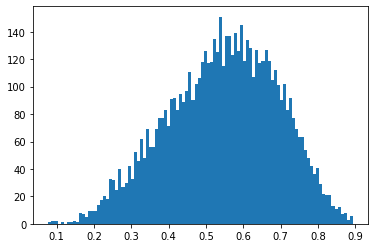

2331

In [125]:
plt.hist(a, bins=100)
plt.show()
len(a[a<0.5])

In [ ]:
np.where(a < 0.1)

(array([  55,  111,  114,  194,  236,  238,  305,  310,  317,  362,  367,
         375,  376,  525,  526,  689,  886, 1026, 1427, 1551, 1552, 1559,
        1725, 1750, 1914, 1915, 2002, 2021, 2030]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]))

In [ ]:
enc_test['example'][1900:1940]

[87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88,
 88]

In [ ]:
dev['sent'].iloc[87]

['Dear local news paper, I am writing about your question about the affects of computers.',
 'I think that it does benefit society because you can learn about cultures, you can see all the places in the world, you can interact with your family and friends, and lastly it helps you with hand eye coordination.',
 'On computers you can learn about all the cultures of the world, right at your fingertips.',
 'Also if you want to know what they do or eat or do for fun you can look that up with a click of a mouse.',
 'No more going to the library and spending hours looking up different places in the enciclopedia, and not finding much.',
 'Go on the internet, look it up you are bard to find some culture, or mabe even find out about your culture.',
 'There is countless cultures to see, find a computer, and look something up!',
 'Your bound to learn something knew and exciting.',
 'With a computer you can go around the world.',
 'By on click of the mouse you can go to ect.',
 'With the internet y

In [ ]:
dev['sent'].iloc[464]

['What effect do you believe computers have?',
 'My opinion is that computers have a positive effect on people.',
 'I believe this because, first our government runs on computers.',
 'Next, we can search the web when ever we need to find new about stuff.',
 'Finally, kids can study and do projects online.',
 'To begin, I think computers have a positive effect on people because our whole goverment runs on them.',
 'Without computers our state could be a disaster!',
 'Our government uses them to keep tracks of their files.',
 'They use computers to keep important data.',
 'Whether its for money, meetings or anything else.',
 'We can always count on computers to keep us on tract and organized.',
 'Next, computers can help us a lot in this world.',
 'Another reason why they are a positive thing is because we can always go online to see important news we need to know.',
 'Most people are way to busy to watch t.v., others just watch the news but when you turn on the t.v.',
 'Its too late!',


3 sentence clique model
